In [2]:
# MODULE IMPORTS
import os
import sys
sys.path.append("..")
from deconfounder.causal_tree import CausalTree
from deconfounder.deconfounder_tree_tmp import DeconfounderTree
# OTHER IMPORTS
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
from sklearn.model_selection import train_test_split

Generate data

In [3]:
np.random.seed(42)
data_size = 5000
feature_size = 10
coefs = npr.uniform(size=feature_size) - 0.5
causal_coefs = np.zeros(feature_size)
# Only the first coefficient is causal
coefs[0] = 0.2
causal_coefs[0] = 1
X = npr.binomial(1, 0.5, size=(data_size, feature_size))
T = npr.binomial(1, 0.5, size=data_size)
Yu = np.dot(X, coefs * (causal_coefs == 0))
Yt = np.dot(X, coefs) - 0.1
Effect = Yt - Yu
Y = T*Yt + (1-T)*Yu
X = pd.DataFrame(X)
X['treated'] = T

Try causal tree.

Best parameters set found on development set:
{'min_samples_leaf': 460}
Max Causal Impact: 0.05
Model Causal Impact: 0.05
Average Causal Impact: -0.01


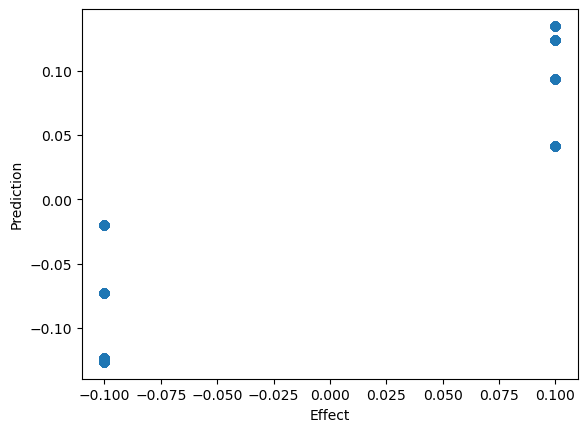

In [28]:
# Split data
X_train, X_test, \
y_train, y_test, \
effect_train, effect_test, \
t_train, t_test = train_test_split(X, Y, Effect, T, random_state=42, test_size=0.20)
# Build causal tree
tuned_parameters = [{'min_samples_leaf': range(200, 800, 20)}]
clf = GridSearchCV(CausalTree(), tuned_parameters, cv=10)
clf.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(clf.best_params_)
pred = clf.predict(X_test)
# Make the causal tree identifies the only causal feature
plt.scatter(effect_test, pred)
plt.xlabel("Effect")
plt.ylabel("Prediction")

def causal_impact(decisions):
    return effect_test[decisions].mean() * decisions.mean()

print (f"Max Causal Impact: {causal_impact(effect_test>0):.2f}")
print (f"Model Causal Impact: {causal_impact(pred>0):.2f}")
print (f"Average Causal Impact: {causal_impact(np.full(effect_test.size, True)):.2f}")

Try deconfounder tree with random scores.

In [30]:
# Create random scores
np.random.seed(42)
scores_train = npr.uniform(size=effect_train.size) - 0.5
scores_test = npr.uniform(size=effect_test.size) - 0.5

# Build deconfounder tree
tuned_parameters = [{'min_samples_leaf': range(200, 800, 20)}]
dt = GridSearchCV(DeconfounderTree(), tuned_parameters, cv=10)
comb = pd.DataFrame(np.array([t_train, 
                              y_train, 
                              scores_train, 
                              np.zeros(scores_train.size)]).T, 
                    columns=["t", "y", "scores", "cost"])
dt.fit(X_train, comb)
print("Best parameters set found on development set:")
print(dt.best_params_)
corrected_scores = scores_test - dt.predict(X_test.values)

print (f"Uncorrected Causal Impact: {causal_impact(scores_test>0):.2f}")
print (f"Corrected Causal Impact: {causal_impact(corrected_scores > 0):.2f}")

Best parameters set found on development set:
{'min_samples_leaf': 200}
Uncorrected Causal Impact: -0.01
Corrected Causal Impact: -0.00


There is something wrong with the implementation of the deconfounder tree. Even if the scores are random, the algorithm should be able to learn that it should split according to X1. Then, it should learn to choose a very high threshold when X1 = 0 and a very low threshold when X2. 